In [1]:
import pandas as pd
import yfinance as yf
import itertools

import pennylane as qml
import matplotlib.pyplot as plt

from pennylane import numpy as np

In [2]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  "font.size": 16,
  "grid.alpha": 0.25})

For more than 20 qubits, use 
```py
dev = qml.device("lightning.qubit", wires=2)
```

## References
- (Izaac, 2021) - Measurement optimization. https://pennylane.ai/qml/demos/tutorial_measurement_optimize   
- (Gokhale et al, 2019) - Minimizing State Preparation in Variational Quantum
  Eigensolver by Partitioning into Commuting Families
- (Peruzzo et al., 2014) - A variational eigenvalue solver on a photonic 
  quantum processor
- (Crawford et al., 2021) - Efficient quantum measurement of Pauli oeprators 
  in the presence of finite sampling error
- (Wecker et al., 2015) - Progress towards practical quantum variational algorithms
- (Kandala et al., 2017) - Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets
- https://docs.pennylane.ai/en/stable/code/api/pennylane.QNGOptimizer.html
- (Castaldo, 2022) - How to choose your optimizer. https://pennylane.ai/blog/2022/06/how-to-choose-your-optimizer/

Return distribution $r_i$
$$
  r_i = \frac{p_i - p_{i-1}}{p_{i-1}}
$$
where $p_i$ is an asset price.

The corresponding mean and variance
$$
  \mu = \frac{1}{N}\sum_{i=1}^N r_i,
$$

$$
  \sigma = \sqrt{\sum_{i=1}^N \frac{(r_i - \mu)^2}{N}}
$$

The expected return for a portfolio is calculated by multiplying dot product 
of weight $\mathbf{x} = [w_1, w_2, \ldots, w_n]$ and expected return for
each asset,
$$
  \mathbf{\mu}^\mathsf{T} \mathbf{x}
$$
and the risk for this portfolio is $\sqrt{\mathbf{x}^\mathsf{T} \mathbf{\sigma} \mathbf{x}}$

Two types of objective functions that are used in portfolio optimization

1. Maximizing the Sharpe Ratio
   $$
     \text{Sharpe Ratio} = \frac{R_p - R_f}{\sigma_p}
   $$

2. Minimizing the following quadratic objective function
   $$
    \min_\mathbf{x} -\mathbf{\mu}^\mathsf{T}\mathbf{x}
      + \gamma \mathbf{x}^\mathsf{T} \mathbf{\sigma} \mathbf{x}, 
        \quad \text{subject to } \mathbf{1}^T \mathbf{x} = B
   $$
   where $B$ is the budget (which is normalized to be set to 1), 
   and $\gamma$ is a risk aversion coefficient that determines  the willing of
   an investor to trade the returns of against risks. The larger the
   $\gamma$ is, the more risk-averse you are. 
   That quadratic objective function is a function that represents a
   risk that you want to take. Minimizing $-\mathbf{\mu}^\mathsf{T} \mathbf{x}$ 
   is equal to get as high as you can the expected return. The second
   term is the risk.

For the purpose of utilizing quantum algorith, we will work with the second 
type. It is easier to transform into an equation that can be solved with quantum
computer. The equationk is a fully-connected Ising model.

<img src="./images/sparse-and-fully-connected-ising-model.png" width=600>

A fully connected Ising model is Currie-Weiss model. The Hamiltonian is
modeled as
$$
  H_\text{int} = \frac{J}{N} \sum_{1 \leq i < j \leq N} s_i s_j
$$

For instance, if $N = 4$
$$
  H_\text{int} = \frac{J}{4} \left[s_1 s_2 + s_1 s_3 + s_1 s_4 
    s_2 s_3 + s_2 s_3 + s_3 s_4\right]
$$

<img src="./images/curie-weiss-model-n-4.png" width=200>

References:
- (Kochmański, 2021) - Curie-Weiss magnet &mdash; a simple model of phase transition
- (Friedli and Velenik, 2017) - Statistical Mechanics of Lattice Systems: 
  A Concrete Mathematical Introduction. https://www.unige.ch/math/folks/velenik/smbook/

There are two constraints types that we can use
1. Continuous weight $\mathbf{x} \in [0, 1] \subset \mathbb{R}^n$, we can choose any weight in 
   $$
      \{ \mathbf{x} \mid \mathbf{1}^\mathsf{T} \mathbf{x} = 1\}
   $$

2. Discrete weight $\mathbf{x} \in \{0, 1\}^n$, we can include or not the asset
   $$
      \{ x \mid x \in \{0, 1\}^n, \mathbf{1}^\mathsf{T} \mathbf{x} = B\}
   $$
   where $B$ in here is the total number of assets that you can include in 
   your portfolio. This represents your budget.


For the first constraint, we can solve it analytically by taking derivative
with respect to $\mathbf{x}$ and set it to be equal to 0. 
But for the second constraint, it is NP-hard problem, and there is no 
efficient algorithm to solve it.    

Read (Punnen, 2020) for the proof that QUBO is subset of Max-cut problem
and Max-cut is NP-hard problem.

We can transform constrained problem above into unconstrained problem, with the 
help of Lagrange multiplier $P$

$$
  \min_{\mathbf{x}} \left(- \mathbf{\mu}^\mathsf{T} \mathbf{x} 
    + \gamma \mathbf{x}^l\mathsf{T} \mathbf{\sigma} \mathbf{x} 
    + P(\mathbf{1}^\mathsf{T}\mathbf{x} - B)^2\right)
$$

Tranformation between QUBO problem and fully-connected Ising model

$$
  \min_{x_i \in \{0, 1\}} \sum_{i, j} Q_{ij} x_i x_j
    + \sum_i k_i x_i 
    \xleftrightarrow{\quad x_i = \frac{1 - z_i}{2} \quad }
  \min_{z_i \in \{1, -1\}} \sum_{i,j} J_{ij} z_i z_j
    + \sum_i h_i z_i + C
$$

We calculate the ground state of the Hamiltonian with VQE or QAOA.   
Several resource for learning it
- https://quantum.cloud.ibm.com/learning/en
- https://pennylane.ai/codebook/learning-paths

For our problem, we have the fully-connected Ising model
$$
\begin{align*}
&\min_{z_k \in \{-1, 1\}}
    \sum_i \sum_{j>i} \frac{(\gamma \sigma_{ij} + P)}{2}  z_i z_j  
    + \sum_i \left(
      -\frac{\gamma}{2}\sum_{j} \sigma_{ij}   + \frac{\mu_i}{2} 
      -\frac{P}{2}\left(n - 2B\right) \right)z_i \\
    &\qquad\qquad+ \frac{\gamma}{4} \sum_{i} \sum_{j} \sigma_{ij}
      + \frac{\gamma}{4} \sum_{i} \sigma_{ii} 
      - \frac{1}{2}\sum_{i} \mu_i 
      + \frac{P}{4} \left( n + \left(n - 2B\right)^2\right) 
\end{align*}
$$

The detailed calculation is in [qubo-to-hamiltoinain.md](./qubo-to-hamiltonian.md)

In [3]:
assets = "AAPL MSFT AMZN TSLA GOOG BRK-B"
StockStartDate = "2018-01-01"
StockEndDate = "2018-12-31"
interval = "1d"

df = yf.download(assets, start=StockStartDate, end=StockEndDate, 
                  interval=interval, auto_adjust=True)["Close"]     # no need to use "Adj Close"
display(df)

# daily return distribution
ret = df.pct_change().dropna()
display(ret)

# mean return vector & covariance matrix (annualized)
# N_days of trading annually
R = ret.mean()*len(ret)
Sigma = ret.cov()*len(ret)

display(R)
display(Sigma)

[*********************100%***********************]  6 of 6 completed


Ticker,AAPL,AMZN,BRK-B,GOOG,MSFT,TSLA
Date,,,,,,
2018-01-02,40.426815,59.450500,197.220001,52.935345,79.328522,21.368668
2018-01-03,40.419788,60.209999,199.789993,53.804184,79.697739,21.150000
2018-01-04,40.607521,60.479500,200.690002,53.999020,80.399178,20.974667
2018-01-05,41.069862,61.457001,201.419998,54.785843,81.395973,21.105333
2018-01-08,40.917320,62.343498,202.740005,55.019951,81.479027,22.427334
...,...,...,...,...,...,...
2018-12-21,35.905136,68.872498,192.100006,48.687595,92.231987,21.318001
2018-12-24,34.976124,67.197998,187.759995,48.522575,88.382324,19.692667
2018-12-26,37.439198,73.544998,197.570007,51.665890,94.419685,21.739332


Ticker,AAPL,AMZN,BRK-B,GOOG,MSFT,TSLA
Date,,,,,,
2018-01-03,-0.000174,0.012775,0.013031,0.016413,0.004654,-0.010233
2018-01-04,0.004645,0.004476,0.004505,0.003621,0.008801,-0.008290
2018-01-05,0.011386,0.016163,0.003637,0.014571,0.012398,0.006230
2018-01-08,-0.003714,0.014425,0.006554,0.004273,0.001020,0.062638
2018-01-09,-0.000115,0.004676,0.001381,-0.000614,-0.000680,-0.008085
...,...,...,...,...,...,...
2018-12-21,-0.038896,-0.057077,-0.007645,-0.029591,-0.032312,0.013920
2018-12-24,-0.025874,-0.024313,-0.022592,-0.003389,-0.041739,-0.076242
2018-12-26,0.070422,0.094452,0.052248,0.064780,0.068310,0.103930


Ticker
AAPL    -0.041942
AMZN     0.282228
BRK-B    0.049668
GOOG     0.012727
MSFT     0.212027
TSLA     0.207649
dtype: float64

Ticker,AAPL,AMZN,BRK-B,GOOG,MSFT,TSLA
Ticker,,,,,,
AAPL,0.081864,0.067913,0.034002,0.054638,0.056270,0.053187
AMZN,0.067913,0.129373,0.040209,0.075713,0.078517,0.074963
BRK-B,0.034002,0.040209,0.050720,0.038682,0.040695,0.037679
GOOG,0.054638,0.075713,0.038682,0.078531,0.065171,0.055626
MSFT,0.056270,0.078517,0.040695,0.065171,0.079437,0.064274
TSLA,0.053187,0.074963,0.037679,0.055626,0.064274,0.340792


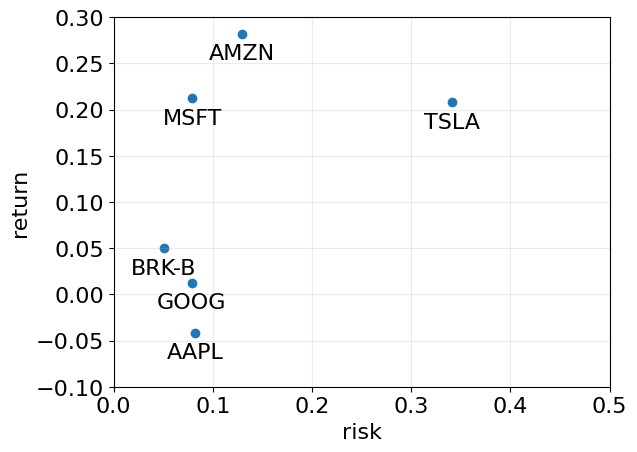

In [8]:
fig, ax = plt.subplots()

xy_scatter = np.array([np.diag(Sigma), R]).T
ax.scatter(xy_scatter[:, 0], xy_scatter[:, 1])

for idx, ticker_name in enumerate(ret.columns):
  ax.text(xy_scatter[idx, 0], xy_scatter[idx, 1] - 0.01, ticker_name,
          ha="center", va="top")
ax.set_xlim([0., 0.5])
ax.set_ylim([-0.1, 0.3])

ax.grid("on")
ax.set_xlabel("risk")
ax.set_ylabel("return")

plt.show(fig)

I restructured the function such that it has a better flow.

In [9]:
# define parameters for the Hamiltonian
n = 6         # number of total assets
gamma = 1     # risk aversion coefficient
B = 3         # budget
P = 1.0       # penalty

Using the given ansatz from (Chen, 2023) will result
in cost_function > -1.7.

I changed the ansatz into `StronglyEntanglingLayers`
and it gives a correct result. I knew this ansatz from
PennyLane Codercise V.2.1 - Introductiont to VQE

In [39]:
# Design the ansatz
def ansatz(params, qubits, depth=2):
  """
  A heuristic ansatz function. See (Kandala  et al., 2017) for the description
  of hardware efficient ansatz
  
  Args:
    depth (int): The number of circuit repetition. Default is 2
  """  
  for q in range(qubits):
    qml.RY(params[q], wires=q)
  for d in range(1, depth+1):
    for q in range(qubits-1):
      qml.CNOT(wires=[q, q+1])

    for q in range(qubits):
      qml.RY(params[d*qubits + q], wires=q)


def strongly_entangling_ansatz(params, qubits, depth=2):
  """
  From PennyLane Codercise V.2.1 - Introduction to VQE
  """
  qml.StronglyEntanglingLayers(weights=params, wires=range(qubits))



In [40]:
# Define Hamiltonian
ZZ = [qml.PauliZ(i)@qml.PauliZ(j) for i in range(n) for j in range(i+1, n)]
ZZ_coeff = [0.5*(gamma*Sigma.values[i][j] + P) for i in range(n)
  for j in range(i+1, n)]

Z = [qml.PauliZ(i) for i in range(n)]
Z_coeff = [-0.5*gamma*(sum(Sigma.values[i][:])) + 0.5*R.iloc[i] - 0.5*P*(n-2*B)
  for i in range(n)]


C = [qml.Identity(i) for i in range(n)]
C_coeff = [0.25*gamma*(sum(sum(Sigma.values)) + np.trace(Sigma)) \
    - 0.5*sum(R) + 0.25*P*(n - (n - 2*B)**2) for i in range(n)] 

# Construct the problem Hamiltonian
# obs = ZZ + Z + C
# coeffs = ZZ_coeff + Z_coeff + C_coeff
obs = ZZ + Z
coeffs = ZZ_coeff + Z_coeff
H = qml.Hamiltonian(coeffs, obs, grouping_type="qwc") 

In [42]:
dev = qml.device("default.qubit", wires=n)
# dev = qml.device("lightning.qubit", wires=n)    # this give me a wrong answer

# Set the cost function on dev
@qml.qnode(dev, diff_method="parameter-shift")
def cost(x, n, H):
  # ansatz(x, qubits=n)
  strongly_entangling_ansatz(x, n)
 
  return qml.expval(H) 

# For analyze the optimized circuit
@qml.qnode(dev)
def probability_circuit(params, n):
  # ansatz(params, qubits=n)
  strongly_entangling_ansatz(params, n)

  return qml.probs(wires=range(n))

In [43]:
shape = qml.StronglyEntanglingLayers.shape(n_layers=2, n_wires=n)
shape

(2, 6, 3)

In [44]:
p = 2   # circuit repetitions

opt = qml.QNGOptimizer(stepsize=0.02)
max_steps = 600

seed = None
rng = np.random.default_rng(seed)
init_params = rng.random(size=(p+1)*n)
init_params = rng.random(size=(p, n, 3))

params = init_params

print(qml.draw(cost)(params, n, H))

0: ──Rot(0.12,0.60,0.81)─╭●─────────────╭X──Rot(0.35,0.36,0.53)─╭●──────────╭X────┤ ╭<𝓗>
1: ──Rot(0.86,0.66,0.11)─╰X─╭●──────────│───Rot(0.17,0.64,0.75)─│──╭●───────│──╭X─┤ ├<𝓗>
2: ──Rot(0.12,0.52,0.65)────╰X─╭●───────│───Rot(0.70,0.70,0.27)─╰X─│──╭●────│──│──┤ ├<𝓗>
3: ──Rot(0.79,0.01,0.37)───────╰X─╭●────│───Rot(0.40,0.12,0.87)────╰X─│──╭●─│──│──┤ ├<𝓗>
4: ──Rot(0.61,0.56,0.27)──────────╰X─╭●─│───Rot(0.39,0.95,0.85)───────╰X─│──╰●─│──┤ ├<𝓗>
5: ──Rot(0.13,0.08,0.16)─────────────╰X─╰●──Rot(0.95,0.47,0.83)──────────╰X────╰●─┤ ╰<𝓗>


In (Chen 2023) - Part 2, the max_steps is different from the printed out

In [52]:
p = 2   # circuit repetitions

learning_rate = 0.03
# learning_rate = 0.01
# learning_rate = 0.2
opt = qml.QNGOptimizer(stepsize=learning_rate)
# opt = qml.AdamOptimizer(stepsize=learning_rate)
# opt = qml.GradientDescentOptimizer(learning_rate)

max_steps = 800       

seed = None
rng = np.random.default_rng()
# init_params = 0. + (np.pi - 0)*rng.random(size=(p+1)*n) 
init_params = 0. + (np.pi - 0)*rng.random(size=(p, n, 3)) 
# init_params = np.ones((p+1)*n)

# -- from the solution in (Chen, 2023)
# init_params = np.array([
#   -1.359e-05, 3.142e+00, 7.096e-03, 1.0123e-03, 
#   -6.618e-06, 1.611e-03, -6.828e-03, -4.132e-01,
#   -1.570e+00, -1.558e+00, 1.571e+00, 1.572e+00, 
#   3.078e-03, 4.132e-01, 1.571e+00, 1.571e+00,
#   1.571e+00, 1.578e+00])

params = init_params
old_cost = 9_999.999_999
for i in range(max_steps):
  params = opt.step(cost, params, n, H)[0]       # need to access the first tuple
  obj_value = cost(params, n, H)
  if (i + 1) % 5 == 0:
    print("Cost after step {:5d}: {: .7f}".format(i + 1, obj_value))
    if np.round(old_cost, 7) == np.round(obj_value, 7):
      break
    else:
      old_cost = obj_value

print("Optimized parameters: {}".format(params))
print("Optimized objective function value: {}".format(obj_value))


Cost after step     5: -0.8899652
Cost after step    10: -1.1466585
Cost after step    15: -1.3197326
Cost after step    20: -1.4367945
Cost after step    25: -1.5121923
Cost after step    30: -1.5602867
Cost after step    35: -1.5926335
Cost after step    40: -1.6163027
Cost after step    45: -1.6352405
Cost after step    50: -1.6516441
Cost after step    55: -1.6667501
Cost after step    60: -1.6812387
Cost after step    65: -1.6954541
Cost after step    70: -1.7095366
Cost after step    75: -1.7235065
Cost after step    80: -1.7373175
Cost after step    85: -1.7508888
Cost after step    90: -1.7641242
Cost after step    95: -1.7769231
Cost after step   100: -1.7891883
Cost after step   105: -1.8008317
Cost after step   110: -1.8117783
Cost after step   115: -1.8219705
Cost after step   120: -1.8313703
Cost after step   125: -1.8399598
Cost after step   130: -1.8477413
Cost after step   135: -1.8547347
Cost after step   140: -1.8609744
Cost after step   145: -1.8665062
Cost after ste

Final solution : 011010, with prob=1.00000


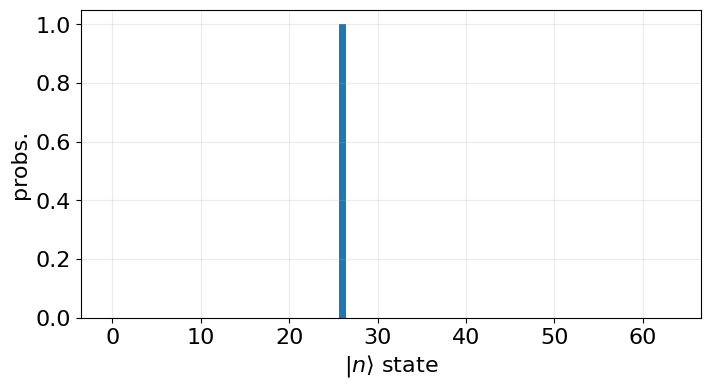

In [54]:
probs = probability_circuit(params, n)
print("Final solution : {:06b}, with prob={:.5f}".format(np.argmax(probs), max(probs)))

fig, ax = plt.subplots(figsize=(8, 4))

ax.bar(range(2 ** len(range(n))), probs)
ax.grid("on")

ax.set_ylabel("probs.")
ax.set_xlabel(r"$|n\rangle$ state")

plt.show(fig)

Check the exact ground state solution

In [55]:
all_combinations = itertools.product([0, 1], repeat=n)

E_g = 99_999.999_99
for x in all_combinations:
  E = gamma*np.dot(x, np.dot(Sigma, x)) - np.dot(R, x) + P*(sum(x)-B)**2
  if E < E_g:
    E_g = E
    sol = x

print("Exact solution: {}".format(sol))

Exact solution: (0, 1, 1, 0, 1, 0)
